---
title: "Evaluating ProtenBERT-GraphSAGE"
date: "06/03/2024"
format:
    html:
        toc: true
        highlight-style: ayu
bibliography: references.bib
categories: [LLM, BERT, Deep learning, GNN]
---

In [1]:
from Bio import Entrez, SeqIO
import pandas as pd
import zipfile
import os
import os.path as osp
import io
import numpy as np

## Data Preparation

This is the third part of the series using ProtenBERT and Graph neural networks (GNNs). On this part, we're gonna use the trained model and see if the protein-protein predictions have sense with a specific dataset. 
The datset we are gonna use comes from a transcriptomic analysis from my thesis (Functional analysis of transcriptomes of *Coffea arabica* L. related to thermal stress) where I identified genes with high expression that belongs to the **Unfolded protein binding** gene ontology.

To use the trained model, we need aminoacids sequences which we dont have at the moment. So, first we need to get all the proteins related to the identified genes from the NCBI proteins database.

First, let's load a csv with the genes:

In [2]:
gene_names_df = pd.read_csv("coffea_arabica_thesis_unfolded_protein_binding.csv", sep=",")
gene_names = list(gene_names_df["gene1"].unique())
gene_names[:5]

['LOC113706996',
 'LOC113695644',
 'LOC113692361',
 'LOC113706995',
 'LOC113707349']

Then, define specific functions to get the protein sequences from NCBI:

In [3]:
def fetch_protein_ids(gene_name):
    """Fetch protein IDs for a given gene name from NCBI."""
    handle = Entrez.esearch(db="protein", term=gene_name)
    record = Entrez.read(handle)
    handle.close()
    return record["IdList"]

def fetch_protein_info(protein_id):
    """Fetch protein information for a given protein ID."""
    handle = Entrez.efetch(db="protein", id=protein_id, rettype="gb", retmode="text")
    record = SeqIO.read(handle, "genbank")
    handle.close()
    return record



Also, let's save the aminoacids sequences to a fasta file:

In [4]:
# List to store all protein records
all_protein_records = []

for gene in gene_names:
    protein_ids = fetch_protein_ids(gene)
    proteins = [fetch_protein_info(pid) for pid in protein_ids]
    all_protein_records.extend(proteins)

# Write all protein sequences to a single FASTA file
with open("coffea_arabica_string_protein_sequences.fa", "w") as output_handle:
    SeqIO.write(all_protein_records, output_handle, "fasta")

print("All protein sequences have been saved to proteins.fasta")

c:\Users\LENOVO\miniconda3\envs\piero\lib\site-packages\Bio\Entrez\__init__.py:723: UserWarning: 
            Email address is not specified.

            To make use of NCBI's E-utilities, NCBI requires you to specify your
            email address with each request.  As an example, if your email address
            is A.N.Other@example.com, you can specify it as follows:
               from Bio import Entrez
               Entrez.email = 'A.N.Other@example.com'
            In case of excessive usage of the E-utilities, NCBI will attempt to contact
            a user at the email address provided before blocking access to the
            E-utilities.
  warnings.warn(


All protein sequences have been saved to proteins.fasta


Once we have the fasta file with all the proteins related to those genes, we need to create an interaction dataframe where we have all the possible pairwise interactions between these proteins. And , save those in a tsv file.

In [6]:
import csv
from Bio import SeqIO
from itertools import combinations

# Read protein sequences from the FASTA file
fasta_file = "coffea_arabica_string_protein_sequences.fa"
protein_ids = [record.id for record in SeqIO.parse(fasta_file, "fasta")]

# Generate all pairwise combinations of protein IDs
pairwise_combinations = combinations(protein_ids, 2)

# Save the pairwise combinations to a CSV file
csv_file = "coffea_arabica_string_interactions.tsv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Protein1", "Protein2"])  # Write header
    for protein1, protein2 in pairwise_combinations:
        writer.writerow([protein1, protein2])

print(f"Pairwise combinations saved to {csv_file}")


Pairwise combinations saved to coffea_arabica_string_interactions.tsv


Also I manually zip the .tsv and the .fasta file.

## Embed Protein Sequences

Now that we have the necesary data to run the model, we need to get the embedding from the aminoacids sequences using ProteinBERT.

In [7]:
from proteinbert import load_pretrained_model
from proteinbert.conv_and_global_attention_model import get_model_with_hidden_layers_as_outputs
import tensorflow as tf

Load the .tsv file:

In [8]:
with zipfile.ZipFile("coffea_arabica_string_interactions.zip", 'r') as z:
        
    file_names = z.namelist()
                    
    tsv_files = [file for file in file_names if file.endswith('interactions.tsv')]

    for tsv_file in tsv_files:
        with z.open(tsv_file) as f:
            df = pd.read_csv(f, sep=',')

Get the unique protein IDs:

In [9]:
unique_proteins = set(df["Protein1"]).union(set(df["Protein2"]))

# Count the number of unique protein names
num_unique_proteins = len(unique_proteins)
print(f"Number of unique proteins: {num_unique_proteins}")

Number of unique proteins: 28


Also, read the protein sequences from the fasta file:

In [10]:
def _read_proteins_from_fasta(fasta_file):

        protein_dict = {}
        for record in SeqIO.parse(fasta_file, "fasta"):
            protein_dict[record.id] = str(record.seq)
        return protein_dict

In [11]:
with zipfile.ZipFile("coffea_arabica_string_interactions.zip", 'r') as z:
    
    file_names = z.namelist()
                    
    tsv_files = [file for file in file_names if file.endswith('protein_sequences.fa')]

    for tsv_file in tsv_files:
        with z.open(tsv_file) as f:
            f_text = io.TextIOWrapper(f)
            protein_sequences_dict = _read_proteins_from_fasta(f_text)

In [12]:
protein_sequences_dict

{'XP_027084939.1': 'MDVRLLGLDAPLVNALHHLIDAADDGDKIANAPTRTYVRDAKAMAATPADVKEYPNSYVFVVDMPGLKSGDIKVQVEDDNVLVVSGERKREEEKEGARYVRMERRVGKFMRKFVLPENANTDAISAVCQDGVLTVTVHKLPPPEPKKPKVVEVKIV',
 'XP_027070567.1': 'MALIPKLFGDMLAPSGLSDETKGIVNARVDWKETPEAHVFKVDLPGLKKEEVKIEVEDGRVLAISGEGAAEKEDKNDKWHRVERSRGRFIRKFLLPENAKVEEVKANMEYGVLTVTIPKQEVKKPEVRAIEISG',
 'XP_027066556.1': 'MALIPKLFGDMLAPSGLSDETKGMVNARVDWKETPEAHVFKVDLPGLKKEEVKVEVEDGRVLAISGERAAEKEDKNDKWHRVERSRGRFTRKFLLPENAKXEEVKANMEYGVLTVTIPKQEVKKPEVRAIEISG',
 'XP_027084938.1': 'MDVRLLGLDAPLVNALHHLIDAADDGDKIANAPTRTYVRDAKAMAATPADVKEYPNSYVFVVDMPGLKSGDIKVQVEDDNVLVVSGERKREEEKEGARYVRMERRVSKFMRKFVLPENANTDAISAVCQDGVLTVTVHKLPPPEPKKPKVVEVKIA',
 'XP_027085429.1': 'MDVRLLGLDAPLVNALHHLIDAADDGDKIANAPTRTYVRDAKAMAATPADVKEYPNSYVFIVDMPGLKSGDIKVQVEDDNVLVVSGERKRAEEKEGARYVRMERRVGKFMRKFVLPENANTDAISAVCQDGVLTVTVHKLPPPEPKKPKVIEVKIV',
 'XP_027084168.1': 'MDVRLMGWDTPLFQTIQHMMDATDDADKTVNAPSRTYVRDTKAMASTPADVKEYPNSYAFIVDMPGLKSGDIKVQVEEDNVLIISGERKREEEKEGAKYVRMERRVGKFMRKFVLPENANTDAISAVCQ

In [13]:
unique_proteins = set(df['Protein1']).union(set(df['Protein2']))


This is to mbe sure that we have all the aminoacids sequences that are avaialble on the .tsv file:

In [14]:
filtered_protein_dict = {protein: seq for protein, seq in protein_sequences_dict.items() if protein in unique_proteins}
filtered_protein_dict


{'XP_027084939.1': 'MDVRLLGLDAPLVNALHHLIDAADDGDKIANAPTRTYVRDAKAMAATPADVKEYPNSYVFVVDMPGLKSGDIKVQVEDDNVLVVSGERKREEEKEGARYVRMERRVGKFMRKFVLPENANTDAISAVCQDGVLTVTVHKLPPPEPKKPKVVEVKIV',
 'XP_027070567.1': 'MALIPKLFGDMLAPSGLSDETKGIVNARVDWKETPEAHVFKVDLPGLKKEEVKIEVEDGRVLAISGEGAAEKEDKNDKWHRVERSRGRFIRKFLLPENAKVEEVKANMEYGVLTVTIPKQEVKKPEVRAIEISG',
 'XP_027066556.1': 'MALIPKLFGDMLAPSGLSDETKGMVNARVDWKETPEAHVFKVDLPGLKKEEVKVEVEDGRVLAISGERAAEKEDKNDKWHRVERSRGRFTRKFLLPENAKXEEVKANMEYGVLTVTIPKQEVKKPEVRAIEISG',
 'XP_027084938.1': 'MDVRLLGLDAPLVNALHHLIDAADDGDKIANAPTRTYVRDAKAMAATPADVKEYPNSYVFVVDMPGLKSGDIKVQVEDDNVLVVSGERKREEEKEGARYVRMERRVSKFMRKFVLPENANTDAISAVCQDGVLTVTVHKLPPPEPKKPKVVEVKIA',
 'XP_027085429.1': 'MDVRLLGLDAPLVNALHHLIDAADDGDKIANAPTRTYVRDAKAMAATPADVKEYPNSYVFIVDMPGLKSGDIKVQVEDDNVLVVSGERKRAEEKEGARYVRMERRVGKFMRKFVLPENANTDAISAVCQDGVLTVTVHKLPPPEPKKPKVIEVKIV',
 'XP_027084168.1': 'MDVRLMGWDTPLFQTIQHMMDATDDADKTVNAPSRTYVRDTKAMASTPADVKEYPNSYAFIVDMPGLKSGDIKVQVEEDNVLIISGERKREEEKEGAKYVRMERRVGKFMRKFVLPENANTDAISAVCQ

To run ProteinBERT, we need to get the longest sequence:

In [15]:
sequences = list(filtered_protein_dict.values())
longest_sequence_length = max(len(seq) for seq in sequences)
longest_sequence_length

346

In [17]:
seq_len = longest_sequence_length+2
global_embeds = []
local_embeds = []
batch_size = 2

Let's define a function that helps us get the embeddings:

In [18]:
def _get_embeddings(seq, seq_len=512, batch_size=1):

    pretrained_model_generator, input_encoder = load_pretrained_model()
    model = get_model_with_hidden_layers_as_outputs(pretrained_model_generator.create_model(seq_len=seq_len))
    encoded_x = input_encoder.encode_X(seq, seq_len)
    local_representations, global_representations = model.predict(encoded_x, batch_size=batch_size)

    return local_representations, global_representations

And use it for all the proteins:

In [19]:
for i in range(0, len(sequences), batch_size):

    batch_seqs = sequences[i:i + batch_size]
    local_representation, global_representation = _get_embeddings(batch_seqs, seq_len=seq_len, batch_size=batch_size)
    global_embeds.extend(global_representation)
    local_embeds.extend(local_representation)
                
global_embeds = np.array(global_embeds)
local_embeds = np.array(local_embeds)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [20]:
print(global_embeds.shape)
print(global_embeds.shape)

(28, 15599)
(28, 15599)


Now that we have the embedings, we need to create the `edge_index` to create a pytorch geometric Data object.

First, we need to encode the protein ID's:

In [21]:
from sklearn import model_selection, metrics, preprocessing

unique_proteins_set = set(df["Protein1"]).union(set(df["Protein2"]))
all_proteins = list(unique_proteins_set)
print(f"All unique proteins: {all_proteins}")

num_unique_proteins = len(all_proteins)
print(f"Number of unique proteins: {num_unique_proteins}")
print(f"Unique proteins: {all_proteins}")

# Fit the LabelEncoder on all unique proteins
lbl_protein = preprocessing.LabelEncoder()
lbl_protein.fit(all_proteins)

# Verify the number of classes
num_classes = len(lbl_protein.classes_)
print(f"Number of classes in LabelEncoder: {num_classes}")
print(f"Classes: {lbl_protein.classes_}")

# Check if there is any discrepancy
if num_classes != num_unique_proteins:
    missing_proteins = unique_proteins_set - set(lbl_protein.classes_)
    print(f"Missing proteins in LabelEncoder: {missing_proteins}")

All unique proteins: ['XP_027063211.1', 'XP_027108429.1', 'XP_027113320.1', 'XP_027089887.1', 'XP_027077852.1', 'XP_027070567.1', 'XP_027096450.1', 'XP_027121387.1', 'XP_027110886.1', 'XP_027105380.1', 'XP_027065019.1', 'XP_027109657.1', 'XP_027122722.1', 'XP_027095883.1', 'XP_027066556.1', 'XP_027110885.1', 'XP_027085429.1', 'XP_027084272.1', 'XP_027084168.1', 'XP_027074077.1', 'XP_027098388.1', 'XP_027084939.1', 'XP_027110883.1', 'XP_027062161.1', 'XP_027125186.1', 'XP_027084938.1', 'XP_027089120.1', 'XP_027084891.1']
Number of unique proteins: 28
Unique proteins: ['XP_027063211.1', 'XP_027108429.1', 'XP_027113320.1', 'XP_027089887.1', 'XP_027077852.1', 'XP_027070567.1', 'XP_027096450.1', 'XP_027121387.1', 'XP_027110886.1', 'XP_027105380.1', 'XP_027065019.1', 'XP_027109657.1', 'XP_027122722.1', 'XP_027095883.1', 'XP_027066556.1', 'XP_027110885.1', 'XP_027085429.1', 'XP_027084272.1', 'XP_027084168.1', 'XP_027074077.1', 'XP_027098388.1', 'XP_027084939.1', 'XP_027110883.1', 'XP_02706216

In [22]:
df["node1_string_id"] = lbl_protein.transform(df.Protein1.values)
df["node2_string_id"] = lbl_protein.transform(df.Protein2.values)

# Verify the transformations
print(f"Transformed Protein1: {df['node1_string_id'].unique()}")
print(f"Transformed Protein2: {df['node2_string_id'].unique()}")

Transformed Protein1: [11  4  3 10 12  7 13 17 22 16 24 20  9 23 25  8 26 27 14  5  6 19 18  1
  0 21  2]
Transformed Protein2: [ 4  3 10 12  7 13 17 22 16 24 20  9 23 25  8 26 27 14  5  6 19 18  1  0
 21  2 15]


In [23]:
df

,Protein1,Protein2,node1_string_id,node2_string_id
0,XP_027084939.1,XP_027070567.1,11,4
1,XP_027084939.1,XP_027066556.1,11,3
2,XP_027084939.1,XP_027084938.1,11,10
3,XP_027084939.1,XP_027085429.1,11,12
4,XP_027084939.1,XP_027084168.1,11,7
...,...,...,...,...
373,XP_027062161.1,XP_027065019.1,0,2
374,XP_027062161.1,XP_027095883.1,0,15
375,XP_027110883.1,XP_027065019.1,21,2
376,XP_027110883.1,XP_027095883.1,21,15


Then, with a helper function create the edge index:

In [24]:
import torch

def _load_edge_csv(df, src_index_col, dst_index_col):
    src = df[src_index_col].values
    dst = df[dst_index_col].values
    edge_index = [src, dst]
    return edge_index

In [25]:
edge_index = _load_edge_csv(df=df, src_index_col="node1_string_id", dst_index_col="node2_string_id")
edge_index = torch.LongTensor(edge_index)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_18068\4265644366.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  edge_index = torch.LongTensor(edge_index)


In [26]:
edge_index

tensor([[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
         11, 11, 11, 11, 11, 11, 11, 11, 11,  4,  4,  4,  4,  4,  4,  4,  4,  4,
          4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 12, 12, 12, 12, 12,
         12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
          7,  7,  7, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
         13, 13, 13, 13, 13, 13, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
         17, 17, 17, 17, 17, 17, 17, 17, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
         22, 22, 22, 22, 22, 22, 22, 22, 22, 16, 16, 16, 16, 16, 16, 16, 16, 16,
         16, 16, 16, 16, 16,

I'm assigning a class to *Coffea arabica*

In [27]:
y = torch.tensor([61], dtype=torch.long)

We have all the necesary to create the Data object:

In [29]:
from torch_geometric.data import Dataset, download_url, extract_zip, Data

global_embeds = torch.tensor(global_embeds, dtype=torch.float)

data = Data(x=global_embeds,edge_index=edge_index, y=y)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_18068\3991706278.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  global_embeds = torch.tensor(global_embeds, dtype=torch.float)


In [35]:
data

Data(x=[28, 15599], edge_index=[2, 378], y=[1])

In [36]:
from torch_geometric.utils import to_networkx

G = to_networkx(data=data)

print(G)

DiGraph with 28 nodes and 378 edges


We can plot the network:

In [37]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

# Visualization function for NX graph or PyTorch tensor
def visualize(h, color, epoch=None, loss=None, accuracy=None, node_size=300):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None and accuracy['train'] is not None and accuracy['val'] is not None:
            plt.xlabel((f'Epoch: {epoch}, Loss: {loss.item():.4f} \n'
                       f'Training Accuracy: {accuracy["train"]*100:.2f}% \n'
                       f' Validation Accuracy: {accuracy["val"]*100:.2f}%'),
                       fontsize=16)
    else:
        nx.draw_networkx(h, pos=nx.spring_layout(h, seed=4572321), with_labels=False,
                         node_color=color, cmap="Set2", node_size=40, alpha=0.6)
    plt.show()

c:\Users\LENOVO\miniconda3\envs\piero\lib\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


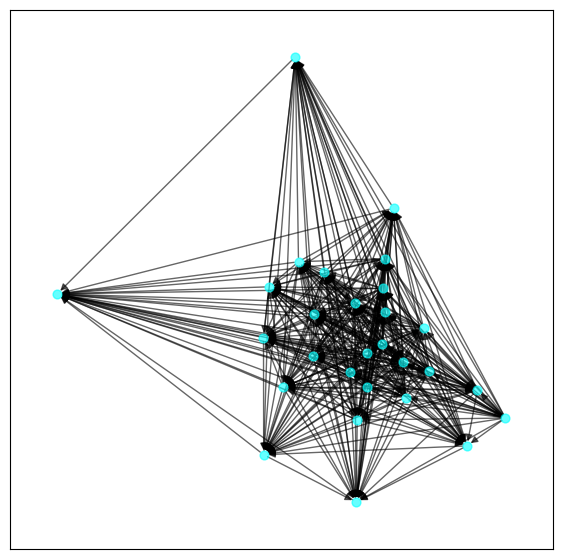

In [38]:
visualize(G, color="cyan")

Every node in this network is connected to all the other nodes. This will change with the model predictions.

Let's see the 2-D dimentional reduction from the embeddings:

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_18068\233343671.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tsne_components[:,0], tsne_components[:,1],c="cyan", cmap="tab20b")


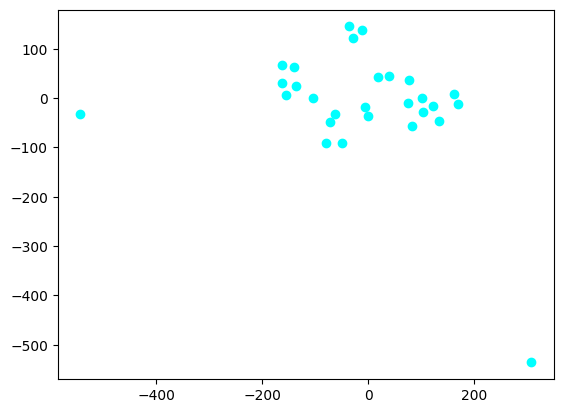

In [39]:
from sklearn.manifold import TSNE

tsne_components = TSNE(n_components=2, perplexity=5, init="pca").fit_transform(data.x)

plt.scatter(tsne_components[:,0], tsne_components[:,1],c="cyan", cmap="tab20b")

## Using the Model

In [40]:
import torch.nn as nn
import torch.nn.functional as F

In [41]:
from torch_geometric.nn import SAGEConv

class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout, num_layers:int, emb=False):
        super(GNNStack, self).__init__()

        
        self.dropout = dropout
        self.num_layers = num_layers
        self.emb = emb

        self.convs = nn.ModuleList()

        for layer in range(self.num_layers):
            in_channels = input_dim if layer == 0 else hidden_dim
            out_channels = hidden_dim 

            self.convs.append(SAGEConv(in_channels, out_channels, normalize=True))

        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(self.dropout),
            nn.Linear(hidden_dim, hidden_dim)
        ) 
    

    def forward(self, x, edge_index):
        
            
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.gelu(x)
            x = F.dropout(x, p=self.dropout,training=self.training)
        
        x = self.post_mp(x)
        

        if self.emb == True:
            return x
            

        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [42]:
class LinkPredictorHead(nn.Module):
    def __init__(self, in_channels:int, hidden_channels:int, out_channels:int, n_layers:int,dropout_probabilty:float=0.3):
        """
        Args:
            in_channels (int):     Number of input features.
            hidden_channels (int): Number of hidden features.
            out_channels (int):    Number of output features.
            n_layers (int):        Number of MLP layers.
            dropout (float):       Dropout probability.
            """
        super(LinkPredictorHead, self).__init__()
        self.dropout_probabilty    = dropout_probabilty  # dropout probability
        self.mlp_layers            = nn.ModuleList()     # ModuleList: is a list of modules
        self.non_linearity         = F.relu              # non-linearity
        
        for i in range(n_layers - 1):                                 
            if i == 0:
                self.mlp_layers.append(nn.Linear(in_channels, hidden_channels))          # input layer (in_channels, hidden_channels)
            else:
                self.mlp_layers.append(nn.Linear(hidden_channels, hidden_channels))      # hidden layers (hidden_channels, hidden_channels)

        self.mlp_layers.append(nn.Linear(hidden_channels, out_channels))                 # output layer (hidden_channels, out_channels)


    def reset_parameters(self):
        for mlp_layer in self.mlp_layers:
            mlp_layer.reset_parameters()

    def forward(self, x_i, x_j):

        x = x_i * x_j                                                     # element-wise multiplication
        for mlp_layer in self.mlp_layers[:-1]:                            # iterate over all layers except the last one
            x = mlp_layer(x)                                              # apply linear transformation
            x = self.non_linearity(x)                                     # Apply non linear activation function
            x = F.dropout(x, p=self.dropout_probabilty,training=self.training)      # Apply dropout
        x = self.mlp_layers[-1](x)                                        # apply linear transformation to the last layer
        x = torch.sigmoid(x)                                              # apply sigmoid activation function to get the probability

        return x

Let's load the model we trained before:

In [44]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

input_dim = data.x.shape[1]
hidden_dim = 1024
dropout = 0.3
num_layers= 3


model          = GNNStack(input_dim, hidden_dim, hidden_dim, dropout,num_layers, emb=True).to(device) # the graph neural network that takes all the node embeddings as inputs to message pass and agregate
link_predictor = LinkPredictorHead(hidden_dim, hidden_dim, 1, num_layers , dropout).to(device)


best_graphsage_model_path      = f"GraphSage_epoch_{404}.pt"
best_link_predictor_model_path =  f"link_predictor_epoch_{404}.pt"

print(f"Loading best models:  {best_graphsage_model_path }  {best_link_predictor_model_path}")
checkpoint = torch.load(best_graphsage_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

checkpoint = torch.load(best_link_predictor_model_path, map_location=device)
link_predictor.load_state_dict(checkpoint['model_state_dict'])
link_predictor.eval()


Loading best models:  GraphSage_epoch_404.pt  link_predictor_epoch_404.pt


LinkPredictorHead(
  (mlp_layers): ModuleList(
    (0-1): 2 x Linear(in_features=1024, out_features=1024, bias=True)
    (2): Linear(in_features=1024, out_features=1, bias=True)
  )
)

Now, let's update our ProteinBERT embeddings:

In [45]:
x = torch.FloatTensor(data.x).to(device)
edge_index = data.edge_index.to(device)

embs = model(x, edge_index)

embs.shape

torch.Size([28, 1024])

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_18068\1092476614.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tsne_components[:,0], tsne_components[:,1],c="cyan", cmap="tab20b")


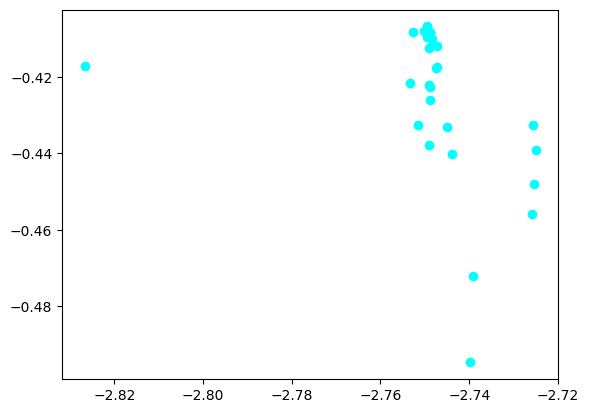

In [61]:
tsne_components = TSNE(n_components=2, perplexity=27, init="pca").fit_transform(embs.detach().cpu().numpy())

plt.scatter(tsne_components[:,0], tsne_components[:,1],c="cyan", cmap="tab20b")

We can see a similar behaviour to the graph we plotted before.

Now, let's pass those embedings to the `LinkPredictorHead` to get the probabilities of protein-protein interactions.

In [62]:
import itertools

def generate_pairs(num_embeddings):
    pairs = itertools.combinations(range(num_embeddings), 2)
    return list(pairs)



In [63]:
pairwise_combinations = generate_pairs(len(embs))

In [64]:
results = []
with torch.no_grad():  # Ensure no gradients are computed
    for i, j in pairwise_combinations:
        vec1 = embs[i].unsqueeze(0)  # Add batch dimension
        vec2 = embs[j].unsqueeze(0)  # Add batch dimension
        prediction = link_predictor(vec1, vec2).item()  # Convert to scalar
        results.append((i, j, prediction))

In [65]:
results

[(0, 1, 0.6516209244728088),
 (0, 2, 0.6353868246078491),
 (0, 3, 0.1549677848815918),
 (0, 4, 0.00240265647880733),
 (0, 5, 0.6596816182136536),
 (0, 6, 0.6366677284240723),
 (0, 7, 0.6536526679992676),
 (0, 8, 0.6611047983169556),
 (0, 9, 0.6263799667358398),
 (0, 10, 0.5428963899612427),
 (0, 11, 0.5935388207435608),
 (0, 12, 0.6135592460632324),
 (0, 13, 0.6762287020683289),
 (0, 14, 0.6489772796630859),
 (0, 15, 0.6287089586257935),
 (0, 16, 0.6755352020263672),
 (0, 17, 0.6885703802108765),
 (0, 18, 0.6545939445495605),
 (0, 19, 0.6656284332275391),
 (0, 20, 0.6443829536437988),
 (0, 21, 0.6490920186042786),
 (0, 22, 0.6958609819412231),
 (0, 23, 0.6536524295806885),
 (0, 24, 0.6821669340133667),
 (0, 25, 0.6490938663482666),
 (0, 26, 0.6867173910140991),
 (0, 27, 0.6356632709503174),
 (1, 2, 0.6407619118690491),
 (1, 3, 0.16379830241203308),
 (1, 4, 0.0026919611264020205),
 (1, 5, 0.663702130317688),
 (1, 6, 0.6410141587257385),
 (1, 7, 0.6575545072555542),
 (1, 8, 0.66506826877

Let's put those probabilities to a sorted dataframe:

In [67]:
results_df = pd.DataFrame(results, columns=["Protein1", "Protein2", "Prediction"])

# Sort the DataFrame by prediction score in descending order
results_df = results_df.sort_values(by="Prediction", ascending=False)

results_df

,Protein1,Protein2,Prediction
225,10,11,0.832046
242,11,12,0.828141
171,7,11,0.786493
85,3,11,0.785781
243,11,13,0.758701
...,...,...,...
118,4,21,0.002742
29,1,4,0.002692
112,4,15,0.002583
3,0,4,0.002403


Here, we can filter out probabilities less than 50%:

In [71]:
mask = results_df["Prediction"] > 0.5
filtered_results_df = results_df[mask]

filtered_results_df

,Protein1,Protein2,Prediction
225,10,11,0.832046
242,11,12,0.828141
171,7,11,0.786493
85,3,11,0.785781
243,11,13,0.758701
...,...,...,...
184,7,24,0.521932
183,7,23,0.520740
217,9,20,0.519688
272,12,27,0.503954


And, get back the protein  ID's:

In [72]:
filtered_results_df["Protein1"] = lbl_protein.inverse_transform(filtered_results_df["Protein1"])
filtered_results_df["Protein2"] = lbl_protein.inverse_transform(filtered_results_df["Protein2"])
filtered_results_df

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_18068\338268944.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_results_df["Protein1"] = lbl_protein.inverse_transform(filtered_results_df["Protein1"])
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_18068\338268944.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_results_df["Protein2"] = lbl_protein.inverse_transform(filtered_results_df["Protein2"])


,Protein1,Protein2,Prediction
225,XP_027084938.1,XP_027084939.1,0.832046
242,XP_027084939.1,XP_027085429.1,0.828141
171,XP_027084168.1,XP_027084939.1,0.786493
85,XP_027066556.1,XP_027084939.1,0.785781
243,XP_027084939.1,XP_027089120.1,0.758701
...,...,...,...
184,XP_027084168.1,XP_027113320.1,0.521932
183,XP_027084168.1,XP_027110886.1,0.520740
217,XP_027084891.1,XP_027109657.1,0.519688
272,XP_027085429.1,XP_027125186.1,0.503954


To check, let's left-join the first dsf to the filtered to see that the protein ID's are correct:

In [73]:
filtered_results_df = pd.merge(
    filtered_results_df,
    df,
    how='left',
    left_on=['Protein1', 'Protein2'],
    right_on=['Protein1', 'Protein2']
)

filtered_results_df = filtered_results_df.drop(columns=['node1_string_id', 'node2_string_id'])
filtered_results_df = filtered_results_df.sort_values(by="Prediction", ascending=False)

# Display the filtered results DataFrame
print(filtered_results_df)


           Protein1        Protein2  Prediction
0    XP_027084938.1  XP_027084939.1    0.832046
1    XP_027084939.1  XP_027085429.1    0.828141
2    XP_027084168.1  XP_027084939.1    0.786493
3    XP_027066556.1  XP_027084939.1    0.785781
4    XP_027084939.1  XP_027089120.1    0.758701
..              ...             ...         ...
290  XP_027084168.1  XP_027113320.1    0.521932
291  XP_027084168.1  XP_027110886.1    0.520740
292  XP_027084891.1  XP_027109657.1    0.519688
293  XP_027085429.1  XP_027125186.1    0.503954
294  XP_027084272.1  XP_027085429.1    0.500549

[295 rows x 3 columns]


And, we can plot the graph with the edges coloured by the predicted probaility of interaction:

In [75]:
import networkx as nx

G = nx.Graph()

# Add edges to the graph
for index, row in filtered_results_df.iterrows():
    G.add_edge(row['Protein1'], row['Protein2'], weight=round(row['Prediction'],3))

# Print some info about the graph
print(G)

Graph with 28 nodes and 295 edges


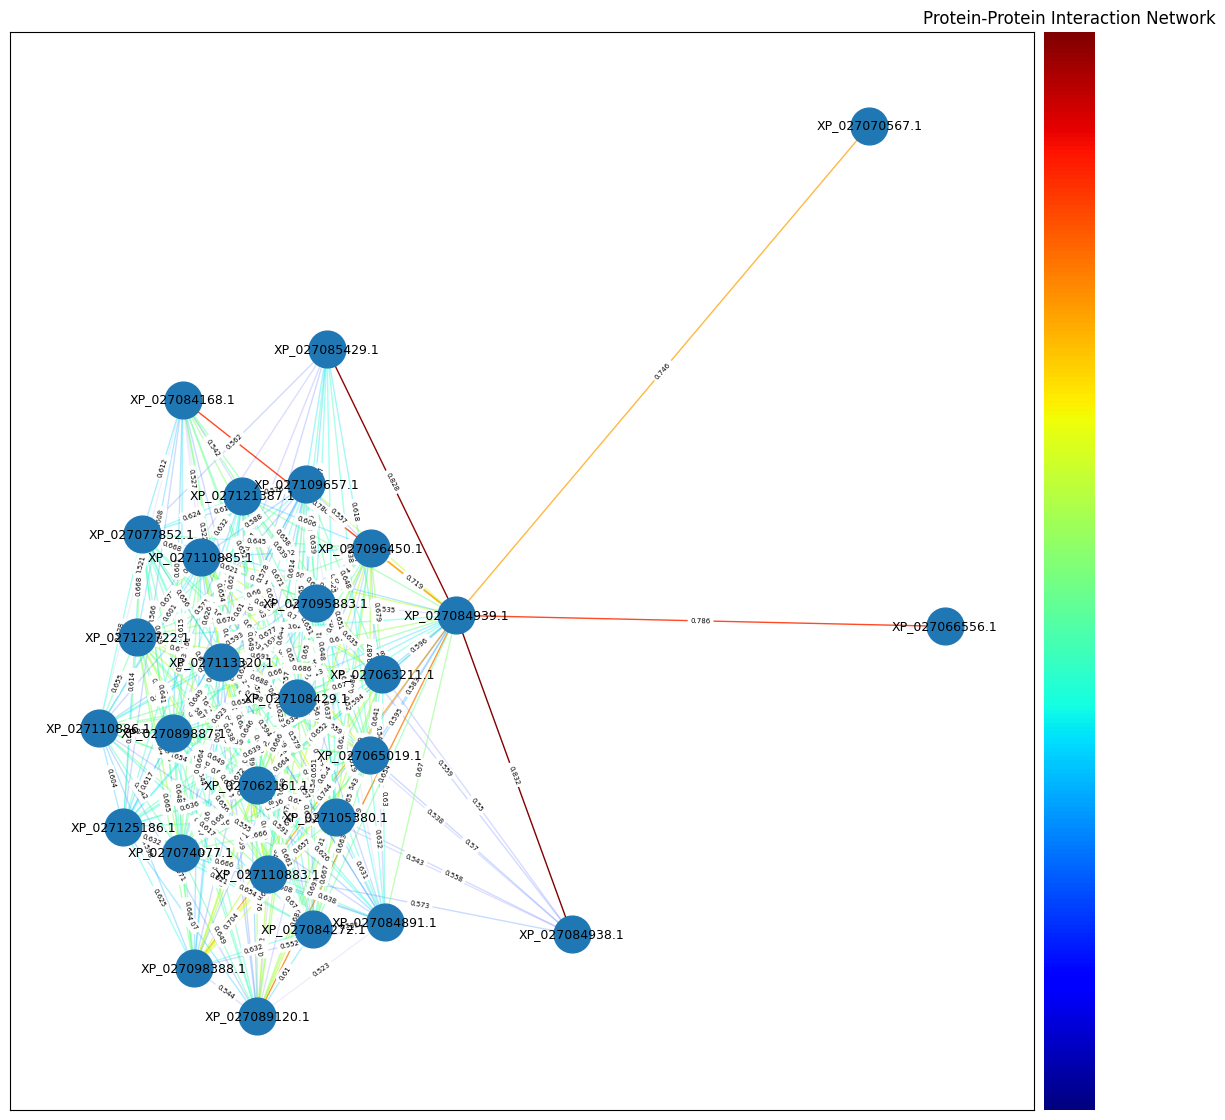

In [76]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Define the plot size and create a subplot
fig, ax = plt.subplots(figsize=(14, 14))

# Define the layout for the nodes
pos = nx.spring_layout(G, seed=120)  # for consistent layout

# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_size=700, ax=ax)

# Get edge weights and normalize them
weights = nx.get_edge_attributes(G, 'weight').values()
norm = mcolors.Normalize(vmin=min(weights), vmax=max(weights))
cmap = cm.jet

# Draw the edges with colors based on the weights
edges = G.edges(data=True)
edge_colors = [cmap(norm(weight['weight'])) for _, _, weight in edges]
edge_alphas = [norm(weight['weight']) for _, _, weight in edges]

nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=1.0, alpha=edge_alphas, ax=ax)

# Draw the labels
nx.draw_networkx_labels(G, pos, font_size=9, font_family="sans-serif", ax=ax)

# Add edge weights as labels (optional)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=5, ax=ax)

# Create a colorbar as a legend
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('Prediction Probability')

# Show the plot
plt.title("Protein-Protein Interaction Network")
plt.axis('off')  # Turn off the axis
plt.savefig("protein_interaction_network.svg", format='svg')
plt.show()


We can see that have a "medium" probaility of interaction based on their protein sequences. Doing a small search, most of the proteins in the messy part of the network are small heatshock protein sequences. It would be interesting to investigate the strong relations and if this have a biological meeaning like: these proteins are in the same compartment?